In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, Binarizer, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import average_precision_score, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline

%matplotlib inline

In [2]:
# Function that combines different classification metrics to avoid repeated large blocks of code.
# Produces the confusion matrix, classification report (precision, recall, f1-score,..)
# ROC-AUC and ROC curve
# Precision-recall curve

def classifier_analysis(clf, X_test, y_test):
    y_predict = clf.predict(X_test_processed)
    y_predict_proba= clf.predict_proba(X_test)[:,1]

    cm = confusion_matrix(y_test, y_predict, labels=[0,1])
    print('tn, fp, fn, tp', cm.ravel())
    _ = ConfusionMatrixDisplay(cm, [0,1]).plot()
    
    print(classification_report(y_test, y_predict))

    logit_roc_auc = roc_auc_score(y_test, y_predict_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba)

    plt.figure()
    plt.plot(fpr, tpr, label=(clf.__class__.__name__ + '(area = %0.2f)' % logit_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    average_precision = average_precision_score(y_test, y_predict_proba)
    precision, recall, thresholds = precision_recall_curve(y_test, y_predict_proba)
    disp = plot_precision_recall_curve(clf, X_test_processed, y_test)
    disp.ax_.set_ylim([0.0, 1.0])
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    plt.show()
    
    return clf

### Random Forest and Logistic Regression modeling of loan status.

In [3]:
loan_data = pd.read_csv('classification_loan_data.csv', index_col=False)

In [4]:
loan_data.nunique()

loan_amnt                     1368
funded_amnt                   1368
funded_amnt_inv               8821
int_rate                       521
installment                  59517
annual_inc                   40081
term                             2
grade                            7
sub_grade                       35
emp_length                      12
home_ownership                   6
verification_status              3
issue_d                        103
purpose                         14
zip_code                       918
addr_state                      51
earliest_cr_line               691
initial_list_status              2
application_type                 2
verification_status_joint        2
loan_status                      2
dtype: int64

Need to take into consideration the time dependence element of this problem. Because we want to predict whether or not
to issue a loan, need to take into consideration the time series nature of the issuance date. The main consideration is during the cross-validation process later but reorder the data now as it will later be transformed by one-hot encoding. Specifically, it will be stored in a sparse matrix which is harder to manipulate.

In [5]:
# This step will be deprecated after newest data cleaning run. 
issued_datetime = pd.to_datetime(loan_data.issue_d)

loan_data = loan_data.loc[issued_datetime.sort_values().index,:]

Create a "hold-out" set of data that will used for final predictions and analysis after all cross-validation and
model learning has been accomplished. The loan issuance dates are aggregated by month, but from the metadata we know that the data is reported *quarterly*. Using this as motivation, the hold-out data will be the most recent quarter. Because the number of loans has grown over time, this one quarter represents nearly $1 / 7$ of all loan data of loans that have either been fully paid or charged off.

In [6]:
# Data goes from second quarter of 2007 to fourth quarter of 2015; the number of samples are skewed toawrds later dates;
# The data is reported quarterly; this should be represented in the cross validation/model selection process.
pind = pd.PeriodIndex(issued_datetime, freq='Q-DEC')

KBins needs numerical variables; use year.quarter (number.decimal). This transformation is not applied to the training data; it's just used

In [7]:
# Add the year to the decimal representing the quarter; Q1 = 0.0 , Q2 = 0.25, Q3 = 0.50, Q4 = 0.75
numerical_quarters = pind.year + (pind.quarter - 1)/4

In [8]:
nb=6
kbd = KBinsDiscretizer(n_bins=nb)
bin_masks = kbd.fit_transform(numerical_quarters.values.reshape(-1, 1)).toarray()

Size of the cross-validation folds

In [9]:
np.sum(bin_masks, axis=0)

array([ 93153.,  90943., 115805., 147183.,  64222., 162063.])

Scikit-learn wants iterable containing (train_indices, test_indices)

In [10]:
train_indices = [loan_data.index[np.array(np.sum(bin_masks[:,:i+1],axis=1), dtype=bool)]  for i in range(nb-1)]
test_indices = [loan_data.index[np.array(bin_masks[:,i+1], dtype=bool)]  for i in range(nb-1)]
train_test_iterable = list(zip(train_indices,test_indices))
holdout_train = loan_data.index[np.array(np.sum(bin_masks[:,:-1],axis=1), dtype=bool)] 
holdout_test = loan_data.index[np.array(bin_masks[:, -1], dtype=bool)] 

Have the cross validation folds, now need to create procedure which correctly preprocesses them before testing. Training component of folds are cumulative over time; always want to use as much information as possible.

There are too many values for the dates of the earliest credit known credit lines and zip codes; too many at least for one-hot encoding to be practical. Therefore, group zip_code by the first two digits as this retains the geographical information and group the earliest credit_line by using KBinsDiscretizer on the year; it needs a numerical value so the entire date cannot be used without modification. The reason for KBinsDiscretizer is that the distribution is not uniform over time, and it presents an unbiased selection/grouping method.

In [11]:
loan_data.loc[:,'zip_code'] = loan_data.zip_code.str.split('xx').str.join(sep='').apply(lambda x : x[:-1])#.astype('category')
loan_data.loc[:, 'earliest_cr_line'] = pd.to_datetime(loan_data.earliest_cr_line).dt.year.astype('object')

In [12]:
loan_data.nunique()

loan_amnt                     1368
funded_amnt                   1368
funded_amnt_inv               8821
int_rate                       521
installment                  59517
annual_inc                   40081
term                             2
grade                            7
sub_grade                       35
emp_length                      12
home_ownership                   6
verification_status              3
issue_d                        103
purpose                         14
zip_code                       100
addr_state                      51
earliest_cr_line                67
initial_list_status              2
application_type                 2
verification_status_joint        2
loan_status                      2
dtype: int64

In [13]:
num_data = loan_data.select_dtypes(exclude=['object'])
cat_data = loan_data.select_dtypes(include=['object'])
loan_data = pd.concat((num_data,cat_data),axis=1)

In [14]:
y = loan_data.loan_status.astype(int)
X = loan_data.drop(columns=['loan_status'])

1
47
14327
673369


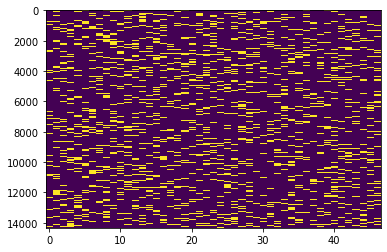

In [15]:
for i in range(1, int(y.shape[0] + 1)):
    if int(y.shape[0]) % i == 0:
        print(i)
plt.imshow(y.values.reshape(-1,47), aspect='auto')

In [16]:
num_features = X.select_dtypes(exclude=['object','category']).columns
cat_features = X.select_dtypes(include=['object','category']).columns

In [17]:
uniq_categories = [list(np.sort(X[col].unique()))+['Missing','Unknown'] for col in cat_features]

In [18]:
# num_transformer = Pipeline(steps=[('scaler', StandardScaler()), ('encoder', KBinsDiscretizer())])
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(categories=uniq_categories,handle_unknown='ignore')
col_transformer = ColumnTransformer(transformers=[('num', num_transformer, num_features), 
                                                  ('cat', cat_transformer, cat_features)])

Special considerations need to be made because the problem is time dependent. The cross validation folds could normally be produced with TimeSeriesSplit(), but the distribution of the continuous numerical variables begs for rescaling. Therein lies the issue; however, as the renormalization using only train

1. Bin categorical data that has too many unique values.
2. Convert categorical data to discrete numerical data by means of OneHotEncoder.

The main goal is to reduce capital loss not maximize profits. Therefore, we value prediction of when a loan will be charged off more than fully paid. We can account for this by changing the class weights in the classification process. This model will reject loans that would have been fully paid in order to avoid loans that will become charged off. In other words, the goal is to maximize the number of true positives, where "positive" in this case is equivalent to a loan being charged off.

tn, fp, fn, tp [76316   385 14028   214]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     76701
           1       0.36      0.02      0.03     14242

    accuracy                           0.84     90943
   macro avg       0.60      0.51      0.47     90943
weighted avg       0.77      0.84      0.78     90943



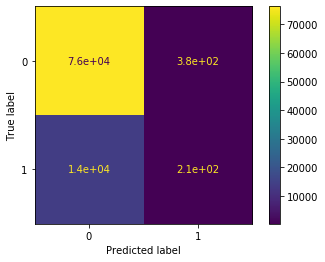

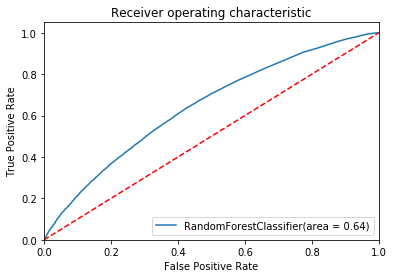

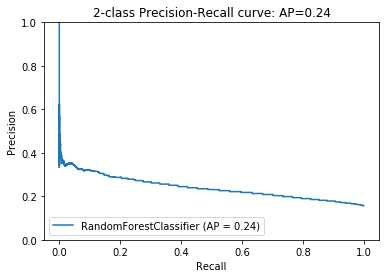

In [21]:
# rfc_models_ = []

for train_indices, test_indices in train_test_iterable:
    X_train, y_train = X.loc[train_indices, :], y.loc[train_indices].values.ravel()
    X_test, y_test = X.loc[test_indices, :], y.loc[test_indices].values.ravel()

    _ = col_transformer.fit(X_train)
    X_train_processed = col_transformer.transform(X_train)
    X_test_processed = col_transformer.transform(X_test)
    class_weights={0:1, 1:1000000}
    
    rfc = RandomForestClassifier(n_jobs=-1, n_estimators=100, class_weight=class_weights, random_state=42)
#     rfc_selector = RFE(rfc, step=(X_train_processed.shape[1]//10))
    rfc.fit(X_train_processed, y_train)
    
#     rfc_models_ += [rfc_selector]
    classifier_analysis(rfc, X_test_processed, y_test)
    break

In [ ]:
lr_models_ = []

for train_indices, test_indices in train_test_iterable:
    X_train, y_train = X.loc[train_indices, :], y.loc[train_indices].values.ravel()
    X_test, y_test = X.loc[test_indices, :], y.loc[test_indices].values.ravel()

    _ = col_transformer.fit(X_train)
    X_train_processed = col_transformer.transform(X_train)
    X_test_processed = col_transformer.transform(X_test)
    class_weights={0:1, 1:1000000}
    
    lr = LogisticRegression(n_jobs=-1, max_iter=300, class_weight=class_weights)
    lr_selector = RFE(lr, step=(X_train_processed.shape[1]//10))
    lr_selector.fit(X_train_processed, y_train)
    
    lr_models_ += [lr_selector]
    classifier_analysis(lr_selector, X_test_processed, y_test)

Use all training/testing data to help scale the holdout data.

In [ ]:
holdoutindicestrain, _ = train_test_iterable[1][0], train_test_iterable[1][1]

In [ ]:
# holdoutindicestrain =  holdout_indices[0][0]
holdoutindicestest = holdout_indices[0][1]

In [ ]:
X_train_holdout = X.loc[holdoutindicestrain, :]#, y.loc[holdoutindicestrain].values.ravel()
X_test_holdout, y_test_holdout = X.loc[holdoutindicestest, :], y.loc[holdoutindicestest].values.ravel()

In [ ]:
X_train_holdout.shape, X_test_holdout.shape, y_test_holdout.shape

In [ ]:
_ = col_transformer.fit(X_train_holdout)
# Just need to fit the column transformer; aren't really training. 
# X_train_holdout_processed = col_transformer.transform(X_train_holdout)
X_test_holdout_processed = col_transformer.transform(X_test_holdout)

In [ ]:
best_model_ = ranfor_models[1][0]

Can't actually use the entire training and testing data to scale/encode because it results in more features than the model has.

In [ ]:
classifier_analysis(best_model_, X_test_holdout_processed, y_test_holdout)

The one hot encoding can throw an error if there are categories in the test set not in the train set; as the categories are
quantities known before hand it should be ok to pass to the encoder; or does this contaminate the test data? The issue is that the lack of a category in the training data prevents accurate prediction as by definition there is no training done on those values.

Is it ok to "look at" the test data? The issue arises when there are categories that are in the testing set that are not
in the training set. If the time-series cross validation folds are not cumulative then this becomes even more of a problem.
If kept as a general procedure, that is, relabel any categories unique to the testing set as "Unknown", then perhaps it can work. I.e. relabel values in the testing set that are "unknown" to the training set; this dummy variable is a flag to the algorithm that these values are "special". From Mike; if we know the categories before hand, use that set of unique values and then add two dummy columns: "Missing" and "Unknown/New"

In [ ]:
# ranfor_param_grid={'n_estimators':[5,10,15]}
# logreg_param_grid = {'tol':[1e-1, 1e-2, 1e-4]}

# ranfor_cv = RandomForestClassifier(class_weight='balanced')
# ranfor_model_ = GridSearchCV(ranfor_cv, ranfor_param_grid, cv=TimeSeriesSplit(n_splits=3))
# ranfor_model_.fit(X_train, y_train)